In [ ]:
import os
import glob
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import cv2
import psutil

import time
import psutil
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim, mean_squared_error as mse


import lpips




# Import your Generator
from model.networks import Generator

plt.rcParams['figure.facecolor'] = 'white'

In [ ]:

def load_model_state(checkpoint_path, device):
    if 'states_pt_places2.pth' in checkpoint_path:
        generator = Generator(checkpoint=checkpoint_path, return_flow=True).to(device)
    else:
        generator = Generator(return_flow=True).to(device)
        state_dict = torch.load(checkpoint_path, map_location=device)
        generator.load_state_dict(state_dict, strict=True)
    return generator

## Load generator model


In [ ]:
use_cuda_if_available = False
sd_path = 'optimized_models/pruned_model_40.pth'
device = torch.device('cuda' if torch.cuda.is_available()
                             and use_cuda_if_available else 'cpu')
generator = load_model_state(sd_path, device)



## Load image and mask


In [ ]:
def resize_output(output, original_size):
    output_image = output.astype(np.uint8)
    output_resized = cv2.resize(output_image, original_size)
    return output_resized




In [ ]:
# Paths
image_path_1 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_image/image15_1000x750.jpg"
mask_path_1 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_masks/mask_1000x750_6x6_center.jpg"

image_path_2 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_image/image2_1000x750.jpg"
mask_path_2 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_masks/mask_1000x750_400x400_random.jpg"

image_path = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_image/image3_500x375.jpg"
mask_path = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_masks/mask_500x375_6x6_center.jpg"

image_path_4 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/Noneed/inpaint/temp/image25_500x375.jpg"
mask_path_4 = "C:/Users/tuant/Downloads/AI Thesis/FINAL_APP_AND_ANALYSIS/examples/final_masks/mask_500x375_50x50_random.jpg"


In [ ]:
# Load image and mask
image_pil = Image.open(image_path)
mask_pil = Image.open(mask_path)

# Save the original size
original_size = image_pil.size



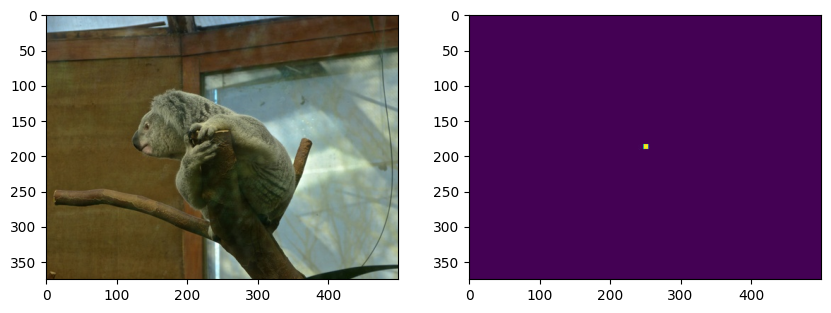

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image_pil)  # plot raw image
ax2.imshow(mask_pil.convert('L'))   # plot mask
plt.show()

In [ ]:
# Convert to tensor
image_tensor = T.ToTensor()(image_pil).to(device)
mask_tensor = T.ToTensor()(mask_pil).to(device)

In [ ]:
# Measure memory usage before model inference
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / 1024 ** 2  # in MB

# Measure time for model inference
start_time = time.time()
output = generator.infer(image_tensor, mask_tensor, return_vals=['inpainted', 'stage1', 'stage2', 'flow'])
elapsed_time = time.time() - start_time

# Measure memory usage after model inference
mem_after = process.memory_info().rss / 1024 ** 2  # in MB
mem_used = mem_after - mem_before
torch.cuda.empty_cache()

In [ ]:
elapsed_time, mem_used

(11.970820903778076, 879.2890625)

Result:


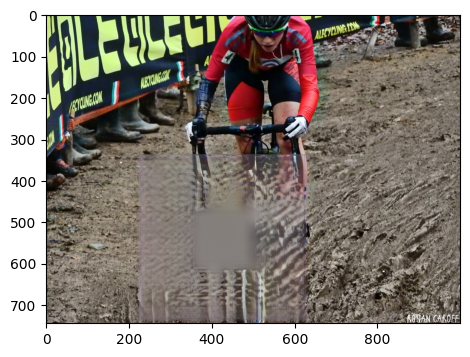

| Raw | Masked |
| Stage1 | Stage2 |


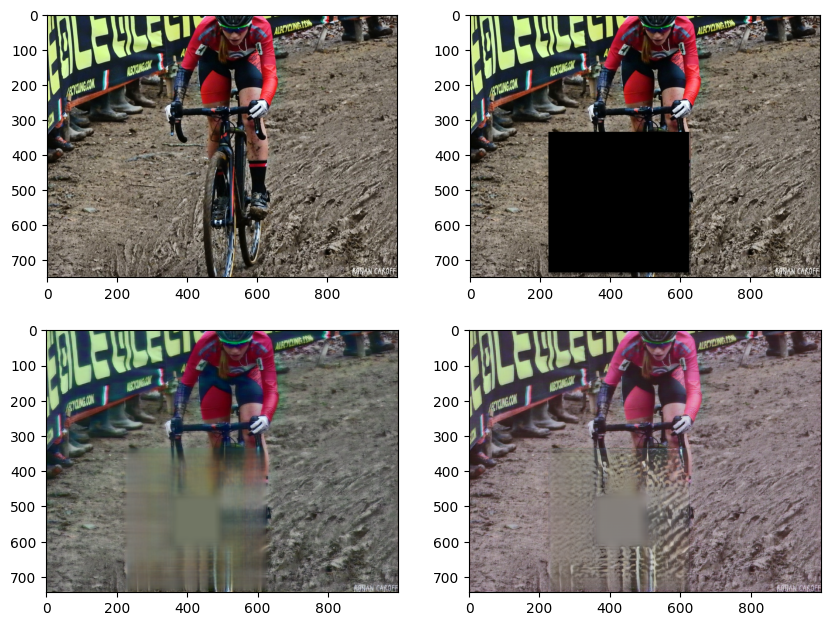

In [ ]:
# Mask-inpainted image in the correct format
mask = (mask_tensor[0:1] > 0.).to(dtype=torch.float32)
image_masked = (image_tensor * (1 - mask)).permute(1, 2, 0).cpu()


print("Result:")
plt.figure(figsize=(6, 4))
plt.imshow(output[0])
plt.show()

w, h = image_pil.size

print("""| Raw | Masked |
| Stage1 | Stage2 |""")
_, axes = plt.subplots(2, 2, figsize=(10*w / max(w,h), 10*h / max(w,h)))
axes[0,0].imshow(image_pil)
axes[0,1].imshow(image_masked)
axes[1,0].imshow(output[1])
axes[1,1].imshow(output[2])
plt.show()

In [ ]:
image_masked_np = image_masked.numpy()
image_masked_np = (image_masked_np * 255).astype(np.uint8)

#Save the image using PIL
image_masked_pil = Image.fromarray(image_masked_np)
image_masked_pil.save('Extra problemen/problem4_masked.png')

In [ ]:
# Save the original size
original_size = image_pil.size
inpainted_resized_np = resize_output(output[0], original_size)

original_np = np.array(image_pil)

In [ ]:
image_output_pil = Image.fromarray(output[0])
image_output_pil.save('Extra problemen/problem2_result.png')


In [ ]:
def extract_roi(original, inpainted, mask):
    mask_np = np.array(mask.convert('L')) / 255  # Ensure binary mask
    roi_original = original[mask_np > 0]
    roi_inpainted = inpainted[mask_np > 0]
    return roi_original, roi_inpainted

In [ ]:
def calculate_metrics(original, inpainted, mask):
    roi_original, roi_inpainted = extract_roi(original, inpainted, mask)

    # Calculate the side length of the square that can fit all pixels
    side = int(np.ceil(np.sqrt(roi_original.shape[0])))

    # Pad arrays to make them square
    pad_size = side * side - roi_original.shape[0]
    roi_original = np.pad(roi_original, ((0, pad_size), (0, 0)), mode='constant')
    roi_inpainted = np.pad(roi_inpainted, ((0, pad_size), (0, 0)), mode='constant')

    # Reshape to square images
    roi_original = roi_original.reshape(side, side, 3)
    roi_inpainted = roi_inpainted.reshape(side, side, 3)

    metrics = {
        'psnr': psnr(roi_original, roi_inpainted, data_range=255),
        'mae': np.mean(np.abs(roi_original - roi_inpainted)),
        'mse': mse(roi_original, roi_inpainted)
    }

    # Only calculate LPIPS if the ROI is large enough
    if side >= 32:  # Minimum size for LPIPS
        # Convert to torch tensors for LPIPS
        roi_original_tensor = torch.from_numpy(roi_original).permute(2, 0, 1).unsqueeze(0).float() / 255.0
        roi_inpainted_tensor = torch.from_numpy(roi_inpainted).permute(2, 0, 1).unsqueeze(0).float() / 255.0

        # Initialize LPIPS model
        loss_fn = lpips.LPIPS(net='alex')
        metrics['lpips'] = loss_fn(roi_original_tensor, roi_inpainted_tensor).item()
    else:
        metrics['lpips'] = None  # or some placeholder value

    return metrics


In [ ]:
original_np = np.array(image_pil).astype(np.uint8)
inpainted_resized_np = resize_output(output[0], original_size).astype(np.uint8)
metrics = calculate_metrics(original_np, inpainted_resized_np, mask_pil)

In [ ]:
metrics

{'psnr': 31.598356783223657,
 'mae': 64.92333333333333,
 'mse': 45.00333333333333,
 'lpips': None}

In [ ]:
{'psnr': 14.474233085956143,
 'mae': 110.76333333333334,
 'mse': 2320.903333333333,
 'lpips': None}

In [ ]:
# Calculate PSNR
psnr_value = psnr(original_np, inpainted_resized_np)
metriculo = calculate_metrics(original_np, inpainted_resized_np)

In [ ]:
# Calculate SSIM
win_size = min(original_np.shape[0], original_np.shape[1], 7)
ssim_value = ssim(original_np, inpainted_resized_np, win_size=win_size, channel_axis=2)


In [ ]:
print(f"PSNR: {psnr_value:.4f}")
print(f"SSIM: {ssim_value:.4f}")


In [ ]:
print(f"PSNR: {psnr_value:.4f}")
print(f"SSIM: {ssim_value:.4f}")

In [ ]:
metriculo